### Task 1: Data Profiling to Understand Data Quality
**Description**: Use basic statistical methods to profile a dataset and identify potential quality issues.

**Steps**:
1. Load the dataset using pandas in Python.
2. Understand the data by checking its basic statistics.
3. Identify null values.
4. Check unique values for categorical columns.
5. Review outliers using box plots.

In [ ]:
# write your code from here

### Task 2: Implement Simple Data Validation
**Description**: Write a Python script to validate the data types and constraints of each column in a dataset.

**Steps**:
1. Define constraints for each column.
2. Validate each column based on its constraints.

In [ ]:
# write your code from here

### Task 3: Detect Missing Data Patterns
**Description**: Analyze and visualize missing data patterns in a dataset.

**Steps**:
1. Visualize missing data using a heatmap.
2. Identify patterns in missing data.

In [ ]:
# write your code from here

### Task 4: Integrate Automated Data Quality Checks
**Description**: Integrate automated data quality checks using the Great Expectations library for a dataset.

**Steps**:
1. Install and initialize Great Expectations.
2. Set up Great Expectations.
3. Add further checks and validate.

In [1]:
! pip install pandas numpy seaborn matplotlib missingno great_expectations


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


--- Task 1: Data Profiling ---

Basic Statistics:
                 id        age         income gender            email
count   100.000000  94.000000     100.000000    100               80
unique         NaN        NaN            NaN      3                3
top            NaN        NaN            NaN   Male  user@domain.com
freq           NaN        NaN            NaN     38               29
mean     50.500000  54.148936   57203.415400    NaN              NaN
std      29.011492  21.186300   47123.951326    NaN              NaN
min       1.000000  18.000000   26828.430000    NaN              NaN
25%      25.750000  37.250000   39845.720000    NaN              NaN
50%      50.500000  55.500000   52217.420000    NaN              NaN
75%      75.250000  70.750000   64177.587500    NaN              NaN
max     100.000000  87.000000  500000.000000    NaN              NaN

Null Values:
 id         0
age        6
income     0
gender     0
email     20
dtype: int64

Unique Values in Categorica

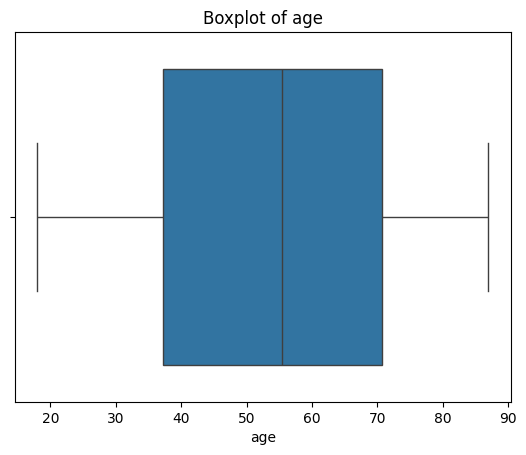

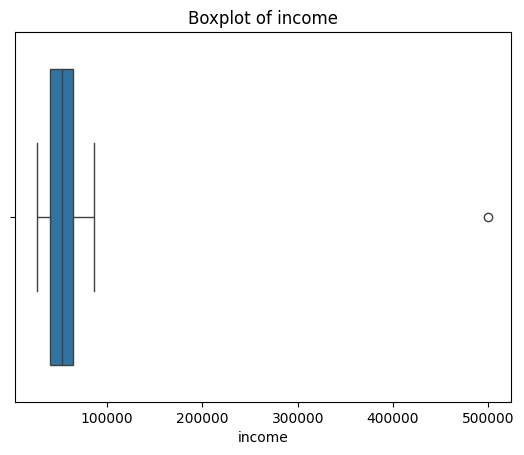


--- Task 2: Data Validation ---

--- Task 3: Missing Data Patterns ---


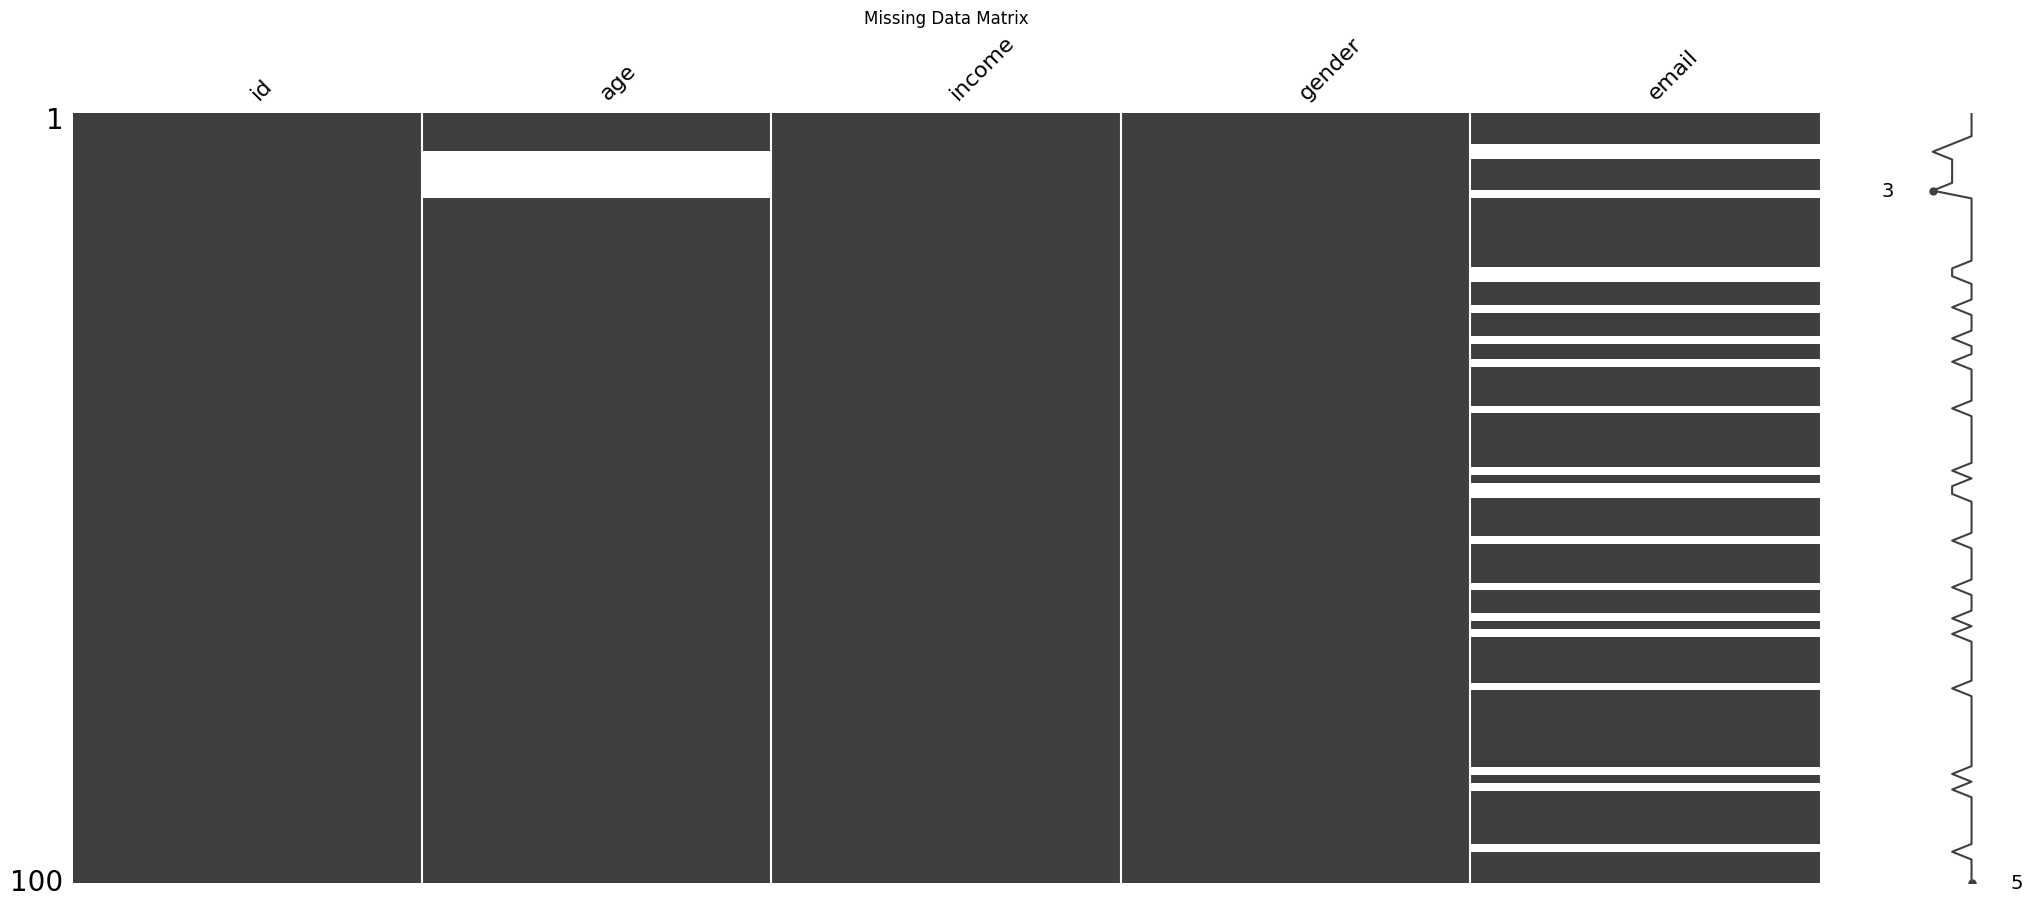

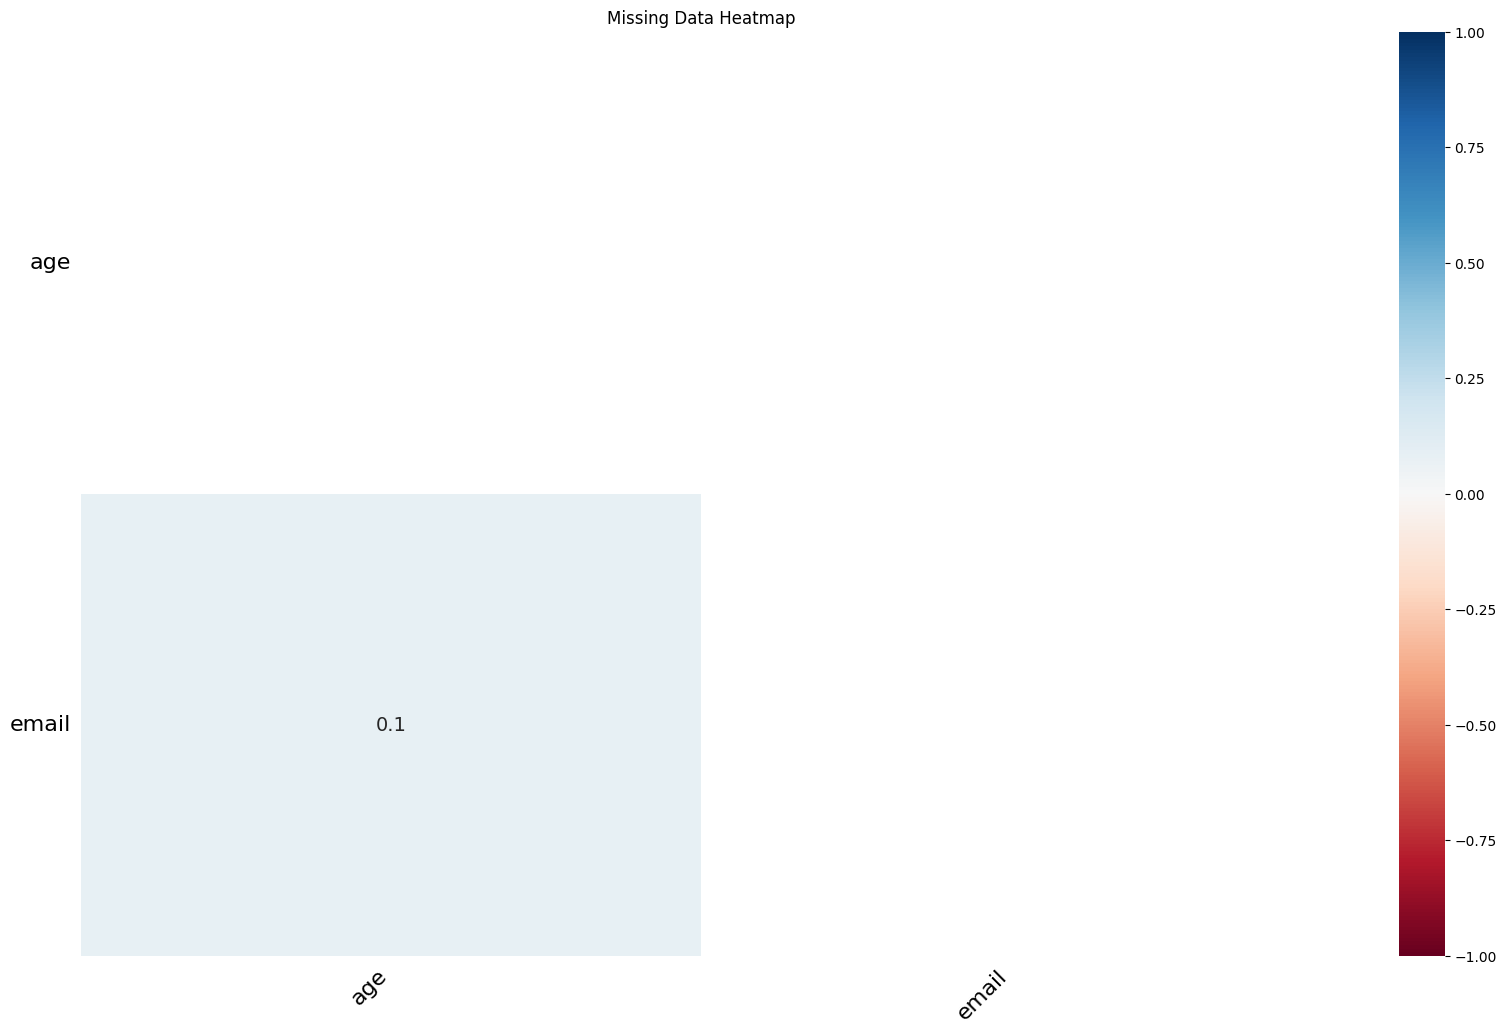


--- Task 4: Great Expectations Validation (Fluent API) ---


AttributeError: 'EphemeralDataContext' object has no attribute 'sources'

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from great_expectations.data_context import get_context
from great_expectations.datasource.fluent import PandasDatasource

# -------------------------------
# Generate Sample Dataset
# -------------------------------
np.random.seed(0)
df = pd.DataFrame({
    "id": np.arange(1, 101),
    "age": np.random.randint(18, 90, 100),
    "income": np.random.normal(50000, 15000, 100).round(2),
    "gender": np.random.choice(["Male", "Female", "Other"], 100),
    "email": np.random.choice([
        "example1@gmail.com", "example2@yahoo.com", None, "user@domain.com"
    ], 100)
})

# Introduce some missing and outlier values
df.loc[5:10, 'age'] = None
df.loc[15, 'income'] = 500000  # outlier income
df.loc[25, 'email'] = None

# -------------------------------
# Task 1: Data Profiling
# -------------------------------
print("--- Task 1: Data Profiling ---")
print("\nBasic Statistics:\n", df.describe(include='all'))
print("\nNull Values:\n", df.isnull().sum())
print("\nUnique Values in Categorical Columns:")
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].nunique()} unique values")

# Box plots for outlier detection
for col in ['age', 'income']:
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

# -------------------------------
# Task 2: Data Validation
# -------------------------------
print("\n--- Task 2: Data Validation ---")

def validate_column_types(df, expected_types):
    for column, expected_type in expected_types.items():
        if not pd.api.types.is_dtype_equal(df[column].dtype, expected_type):
            print(f"Type mismatch in column {column}: Expected {expected_type}, Found {df[column].dtype}")

def validate_column_constraints(df):
    issues = []
    if df['age'].min(skipna=True) < 0 or df['age'].max(skipna=True) > 120:
        issues.append("Age out of valid range.")
    if df['income'].min() < 0:
        issues.append("Income should not be negative.")
    if not df['gender'].isin(["Male", "Female", "Other"]).all():
        issues.append("Invalid gender values.")
    for issue in issues:
        print("Constraint Violation:", issue)

expected_types = {
    'id': np.dtype('int64'),
    'age': np.dtype('float64'),
    'income': np.dtype('float64'),
    'gender': np.dtype('O'),
    'email': np.dtype('O')
}

validate_column_types(df, expected_types)
validate_column_constraints(df)

# -------------------------------
# Task 3: Missing Data Patterns
# -------------------------------
print("\n--- Task 3: Missing Data Patterns ---")
msno.matrix(df)
plt.title("Missing Data Matrix")
plt.show()

msno.heatmap(df)
plt.title("Missing Data Heatmap")
plt.show()

# -------------------------------
# Task 4: Great Expectations Validation (Fluent API)
# -------------------------------
print("\n--- Task 4: Great Expectations Validation (Fluent API) ---")

# Step 1: Get a Data Context
context = get_context()

# Step 2: Add Fluent PandasDatasource
context.sources.add_pandas(name="my_pandas_datasource")

# Step 3: Create a DataAsset from the DataFrame
data_asset = context.sources.my_pandas_datasource.add_dataframe_asset(
    name="sample_df_asset",
    dataframe=df
)

# Step 4: Get the Batch
batch = data_asset.get_batch_list()[0]

# Step 5: Create or update an expectation suite
suite_name = "data_quality_suite"
context.add_or_update_expectation_suite(expectation_suite_name=suite_name)

# Step 6: Get validator
validator = context.get_validator(
    batch=batch,
    expectation_suite_name=suite_name
)

# Step 7: Define Expectations
validator.expect_column_values_to_not_be_null("age")
validator.expect_column_values_to_be_between("age", 0, 120)
validator.expect_column_values_to_be_between("income", 0, 1_000_000)
validator.expect_column_values_to_match_regex("email", r"[^@]+@[^@]+\\.[^@]+")
validator.expect_column_values_to_be_in_set("gender", ["Male", "Female", "Other"])

# Step 8: Validate
results = validator.validate()
print("\nGE Fluent Validation Results:\n")
print(results)


In [3]:
! pip install great_expectations==0.16.16


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 13.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 29.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 54.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 32.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 33.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 34.2 MB/s e

In [ ]:
# write your code from here